# Documentation for the creation and usage of the heatpump library (hplib)




In [2]:
import hplib as hpl
import hplib_database as db
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%html
<style>
table {float:left}
</style>

## Defintions

**Abbreviations**

| Abbreviation | Meaning |
| --- | --- |
| P_th | Thermal output power in W |
| P_el | Electical input Power in W |
| COP | Coefficient of performance |
| T_in | Input temperature in °C at primary side of the heat pump |
| T_out | Output temperature in °C at secondary side of the heat pump |
| T_amb | Ambient temperature in °C |
| P_th_ref | Thermal output power in W at T_in = -7 °C and T_out = 52 °C |
| P_el_ref | Elecrical output power in W at T_in = -7 °C and T_out = 52 °C |
| COP_ref | Coefficient of performance at T_in = -7 °C and T_out = 52 °C |
| p1-p4 | Fit-Parameters for Fit-Function |


**Group IDs**

| Group ID | Type | Subtype |
| --- | --- | --- |
| 1 | Outdoor Air / Water | Regulated | 
| 2 | Brine / Water | Regulated | 
| 3 | Water / Water | Regulated | 
| 4 | Outdoor Air / Water | On-Off | 
| 5 | Brine / Water | On-Off | 
| 6 | Water / Water | On-Off | 

## Database Preparation
1. we downloaded all manufacturer data from https://keymark.eu/en/products/heatpumps/certified-products
2. then we unzipped the files and used the bash-skript to convert pdf into txt
3. afterwards we used this following functions to create and extent the heatpump keymark database

In [ ]:
# Import keymark data and save to csv database
db.import_keymark_data()
# -> this creates /output/database_keymark.csv)

In [ ]:
# Reduce to climate measurement series with average climate, delete redundant entries and save to csv sub-database
db.reduce_keymark_data('database_keymark.csv','average')
# -> this creates /output/database_keymark_average.csv)

In [ ]:
# Normalize electrical and thermal power from the keymark database to values from setpoint T_in = -7 °C and T_out = 52 °C
db.normalize_keymark_data('database_keymark_average.csv')
# -> this creates /output/database_keymark_average_normalized.csv)

In [ ]:
# Identify subtypes like on-off or regulated heat pump and assign group depending on its type and subtype
db.identify_subtypes('database_keymark_average_normalized.csv')
# -> this creates /output/database_keymark_average_normalized_subtypes.csv)

In [2]:
# Calculate parameters p1-p4 for P_th, P_el and COP
db.calculate_function_parameters('database_keymark_average_normalized_subtypes.csv')
# -> this creates the final hplib_database.csv

In [3]:
# Calculate generic heat pump models for each group
db.add_generic()
# -> this overwrites the hplib_database.csv

In [4]:
# Many heat pump models have several entries because of different controller or storage configurations. Reduce to unique heat pump models.
db.reduce_to_unique()
# -> this overwrites the hplib_database.csv

## Usage for simulation

In [3]:
# Have a look into the hplib database
database = hpl.load_database()
database

,Manufacturer,Model,Date,Type,Subtype,Group,Refrigerant,Mass of Refrigerant [kg],SPL indoor [dBA],SPL outdoor [dBA],...,p3_P_th [-],p4_P_th [1/°C],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p4_P_el [1/°C],p1_COP [-],p2_COP [-],p3_COP [-],p4_COP [-]
0,Advantix,i-SHWAK V4 06,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,2.68,35.0,64.0,...,1.284505,-1.780462,255.166152,0.012686,-0.051998,-255.216376,-40.360701,-0.042594,4.862192,40.502338
1,Advantix,i-SHWAK V4 08,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,2.20,35.0,64.0,...,0.923852,141.675167,158.365005,0.012931,-0.043319,-158.414765,221.722238,-0.039243,4.806831,-221.576626
2,Advantix,i-SHWAK V4 10,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,3.45,39.0,64.0,...,1.230384,-22.318136,134.153409,0.011790,0.024663,-134.201011,212.852441,-0.073052,6.208805,-212.682484
3,Advantix,i-SHWAK V4 12,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,3.45,39.0,65.0,...,0.857510,142.590969,-74.400462,0.008599,0.202072,74.352921,318.330520,-0.077418,6.435352,-318.207408
4,Advantix,i-SHWAK V4 14,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,4.40,40.0,68.0,...,0.964394,-212.774961,-71.558958,0.010612,0.062583,71.508022,208.402883,-0.059670,5.518714,-208.245752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,Generic,Generic,NaN,Brine/Water,Regulated,2.0,NaN,NaN,NaN,NaN,...,0.877445,-0.034105,-0.013094,0.013094,0.083754,-0.031737,0.094477,-0.094477,7.965774,-0.002458
507,Generic,Generic,NaN,Water/Water,Regulated,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,Generic,Generic,NaN,Outdoor Air/Water,On-Off,4.0,NaN,NaN,NaN,NaN,...,1.479700,-62.932498,33.078415,0.012577,0.362294,-33.075069,60.048530,-0.060318,5.696027,-59.953197
509,Generic,Generic,NaN,Brine/Water,On-Off,5.0,NaN,NaN,NaN,NaN,...,1.294020,-0.001788,-0.015276,0.015276,0.241917,0.004298,0.103930,-0.103930,8.054636,-0.031898


In [4]:
# Define a specific heatpump model and get parameters
parameters = hpl.get_parameters('i-SHWAK V4 06')
parameters

,Model,P_th_ref [W],P_el_ref [W],COP_ref,Group,p1_P_th [1/°C],p2_P_th [1/°C],p3_P_th [-],p4_P_th [1/°C],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p4_P_el [1/°C],p1_COP [-],p2_COP [-],p3_COP [-],p4_COP [-]
0,i-SHWAK V4 06,4500.0,2866.0,1.57,1.0,1.756924,-0.010648,1.284505,-1.780462,255.166152,0.012686,-0.051998,-255.216376,-40.360701,-0.042594,4.862192,40.502338


In [5]:
# Alternatively, define a "Generic" heatpump model and get parameters
# For every Group ID there is a parameter set which represents an average heatpump of its group
# Please define the Type "Generic", the Group ID (1-9) and P_th_ref in W at given primary input
# (t_in) and secondary output temperature (t_out) in °C.
parameters = hpl.get_parameters(model="Generic", group_id=1, t_in=0, t_out=40, p_th=10000)
parameters

,Model,P_th_ref [W],P_el_ref [W],COP_ref,Group,p1_P_th [1/°C],p2_P_th [1/°C],p3_P_th [-],p4_P_th [1/°C],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p4_P_el [1/°C],p1_COP [-],p2_COP [-],p3_COP [-],p4_COP [-]
0,Generic,7836.473695,5599.013021,1.399617,1.0,60.221014,-0.003619,0.919534,-60.251091,62.707262,0.011106,0.0611,-62.756619,46.08128,-0.087983,7.053688,-45.927145


In [7]:
# Simulate on time step
# Please define primary input temperature (t_in_primary), secondary input temperature (t_in_secondary)
# in °C and the parameters from the previous step. The t_in_secondary is supposed to be heated up by
# 5 K which then results in output temperature (t_out). For a time series create a loop with the function.
P_th, P_el, COP, T_out, m_dot = hpl.simulate(t_in_primary=5, t_in_secondary=35, parameters=parameters, t_amb=5)
print('P_th: '+str(int(P_th))+' W')
print('P_el: '+str(int(P_el))+' W')
print('COP: '+str(round(COP,3)))
print('T_out: '+str(round(T_out,1))+' °C')
print('m_dot: '+str(round(m_dot,3))+' kg/s')

P_th: 6232 W
P_el: 1447 W
COP: 4.305
T_out: 40 °C
m_dot: 0.297 kg/s


**Very important:** With the Fit-Parameters p1-p4 for P_th, P_el and COP it is possible to calculate the results with the following methods:

1. P_th and P_el with Fit-Functions and `COP = P_th / P_el` or
2. P_th and COP with Fit-Functions and `P_el = P_th / COP` or
3. P_el and COP with Fut-Functions and `P_th = P_el * COP`

While the model by Schwarmberger et. al. uses the 1. method, our validation showed, that the 3. method leads to better results. Therefore we decided to implement this in the `simulate` definition.

## Examples

**Schematic plotting** of COP, P_el and P_th for an generic air/water heat pump: subtype = **On-Off** 

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

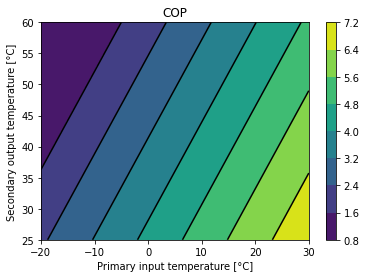

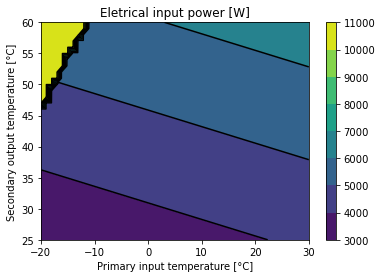

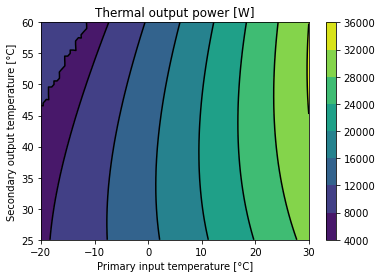

In [8]:
# Define Temperatures
T_in_primary = range(-20, 31) # air temperatur
T_in_secondary = range(20,56) # e.g. temperature from hot water storage

# Load parameters of Generic Air/Water, On-Off
parameters = hpl.get_parameters('Generic', group_id=4, t_in=-7, t_out=52, p_th = 10000)

# Simulate 
names = ['T_in_primary','P_th', 'P_el', 'COP', 'T_out', 'm_dot']
data = []

for t1 in T_in_primary:
    for t2 in T_in_secondary:
        P_th, P_el, COP, T_out, m_dot = hpl.simulate(t1, t2, parameters, t1)
        data.append([t1, P_th, P_el, COP, T_out, m_dot])

results = pd.DataFrame(data, columns=names)

# Plot COP
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in_primary'], results['T_out'], results['COP'])
ax1.tricontour(results['T_in_primary'], results['T_out'], results['COP'], colors='k')
fig1.colorbar(plot)
ax1.set_title('COP')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot electrical input power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in_primary'], results['T_out'], results['P_el'])
ax1.tricontour(results['T_in_primary'], results['T_out'], results['P_el'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Eletrical input power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot thermal output power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in_primary'], results['T_out'], results['P_th'])
ax1.tricontour(results['T_in_primary'], results['T_out'], results['P_th'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Thermal output power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

## Validation

In [10]:
# Simulate every set point for every heatpump and save csv file
df=pd.read_csv('../output/database_keymark_average_normalized_subtypes.csv')
i=0
prev_model='first Model'
while i<len(df): 
    Model=df.iloc[i,1]
    T_amb=df.iloc[i,12]
    T_in=df.iloc[i,13]
    T_out=df.iloc[i,14]
    P_th=df.iloc[i,15]
    P_el=df.iloc[i,16]
    COP=df.iloc[i,17] 
    try:
        if prev_model!=Model:
            para=hpl.get_parameters(Model)
        P_th_sim,P_el_sim,COP_sim,_,_=hpl.simulate(T_in,T_out-5,para,T_amb)
        df.loc[i,'P_th_sim']=P_th_sim
        df.loc[i,'P_el_sim']=P_el_sim
        df.loc[i,'COP_sim']=COP_sim
        prev_model=Model
        i=i+1
    except:
        i=i+1
        pass
df['err_P_th']=df['P_th_sim']/df['P_th [W]']-1
df['err_P_el']=df['P_el_sim']/df['P_el [W]']-1
df['err_COP']=df['COP_sim']/df['COP']-1
df.to_csv('../output/database_keymark_average_normalized_subtypes_validation.csv', encoding='utf-8', index=False)

### Validation Data as Box-Plots

In [11]:
df = pd.read_csv('../output/database_keymark_average_normalized_subtypes_validation.csv')

err_COP     0.120764
err_P_el    0.194564
err_P_th    0.235222
dtype: float64

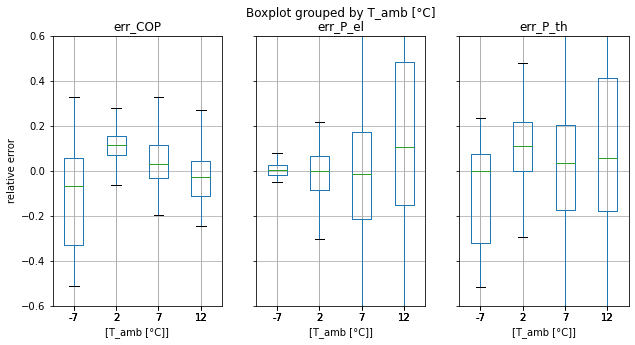

In [12]:
# Plot results for Group 1 (Air/Water, Regulated)
Group = 1
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','err_COP', 'err_P_el', 'err_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-0.6,0.6)
ax[0].set_ylabel('relative error')
data.abs().mean()[1:4] # mean relative error

err_COP     0.042286
err_P_el    0.176503
err_P_th    0.197375
dtype: float64

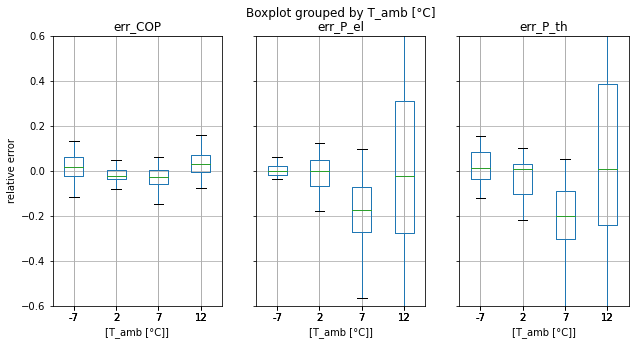

In [13]:
# Plot results for Group 2 (Brine/Water, Regulated)
Group = 2
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','err_COP', 'err_P_el', 'err_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-0.6,0.6)
ax[0].set_ylabel('relative error')
data.abs().mean()[1:4] # mean relative error

err_COP     0.054041
err_P_el    0.025251
err_P_th    0.058066
dtype: float64

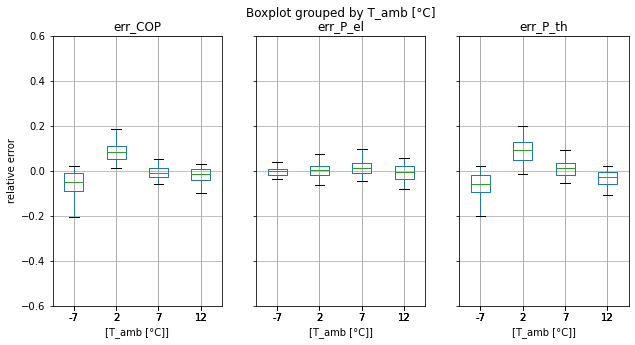

In [14]:
# Plot results for Group 4 (Air/Water, On-Off)
Group = 4
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','err_COP', 'err_P_el', 'err_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-0.6,0.6)
ax[0].set_ylabel('relative error')
data.abs().mean()[1:4] # mean relative error

err_COP     0.038979
err_P_el    0.016784
err_P_th    0.026684
dtype: float64

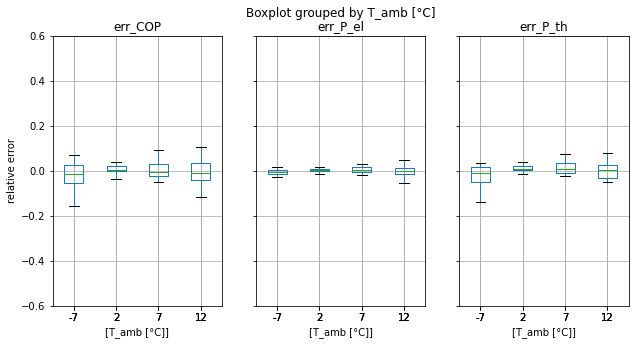

In [15]:
# Plot results for Group 5 (Brine/Water, On-Off)
Group = 5
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','err_COP', 'err_P_el', 'err_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-0.6,0.6)
ax[0].set_ylabel('relative error')
data.abs().mean()[1:4] # mean relative error

err_COP     0.015635
err_P_el    0.015820
err_P_th    0.024154
dtype: float64

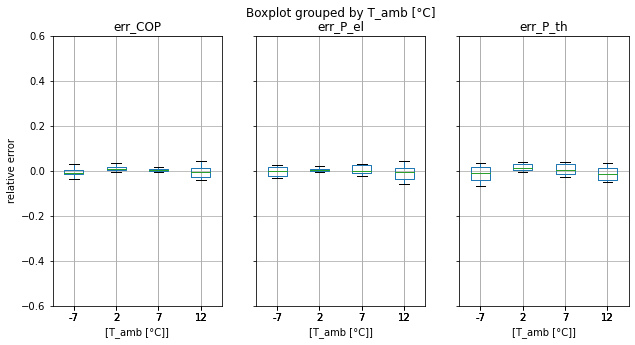

In [16]:
# Plot results for Group 6 (Water/Water, On-Off)
Group = 6
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','err_COP', 'err_P_el', 'err_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-0.6,0.6)
ax[0].set_ylabel('relative error')
data.abs().mean()[1:4] # mean relative error

### Validation-Data as Scatter-Plots

(0.0, 50000.0)

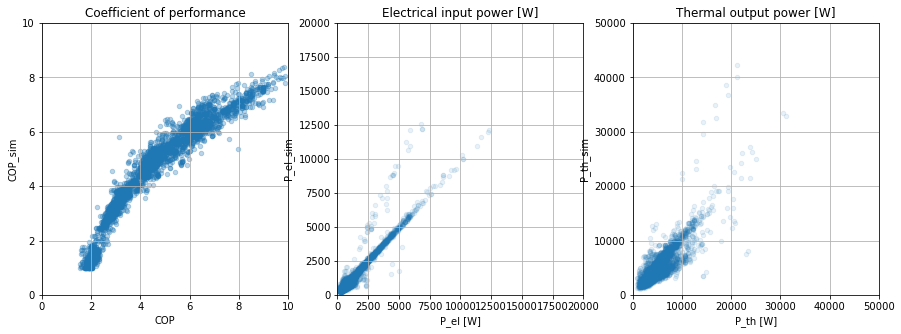

In [20]:
# Plot results for Group 1: Air/Water | Regulated
Group = 1
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

(0.0, 50000.0)

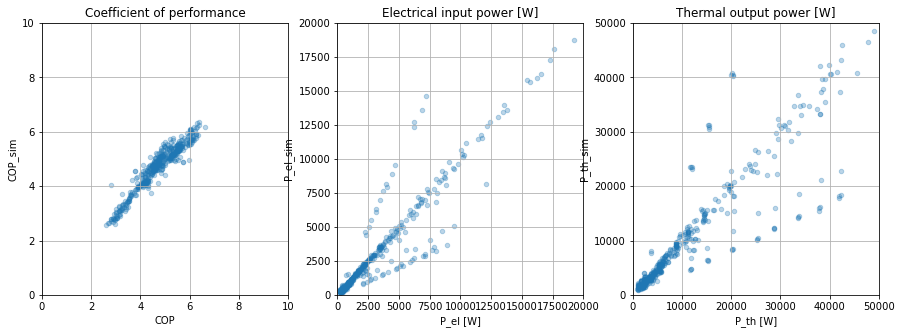

In [21]:
# Plot results for Group 2: Brine/Water | Regulated
Group = 2
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

(0.0, 50000.0)

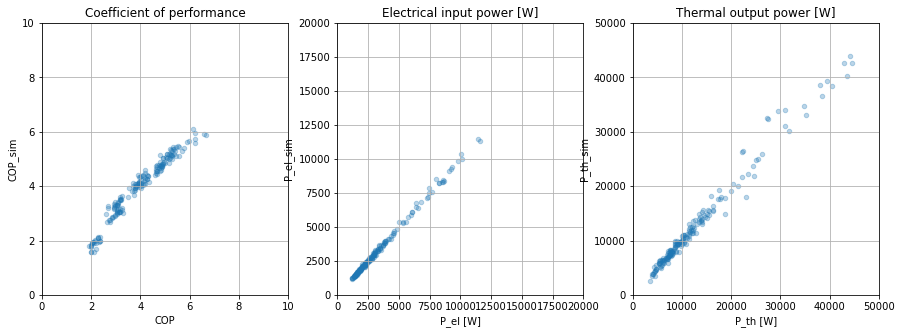

In [22]:
# Plot results for Group 4: Air/Water | On-Off
Group = 4
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

(0.0, 50000.0)

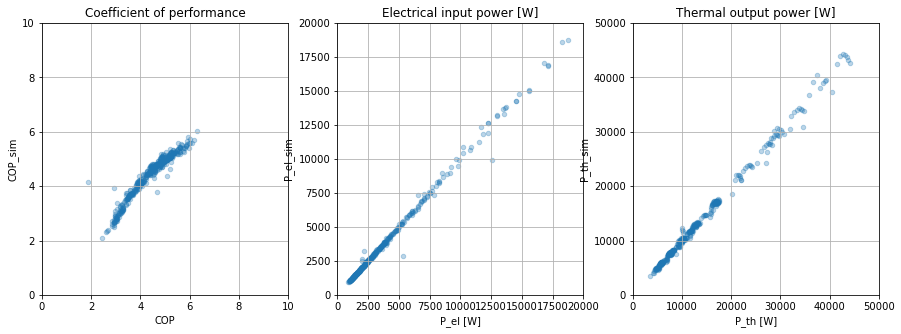

In [23]:
# Plot results for Group 5: Brine/Water | On-Off
Group = 5
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

(0.0, 50000.0)

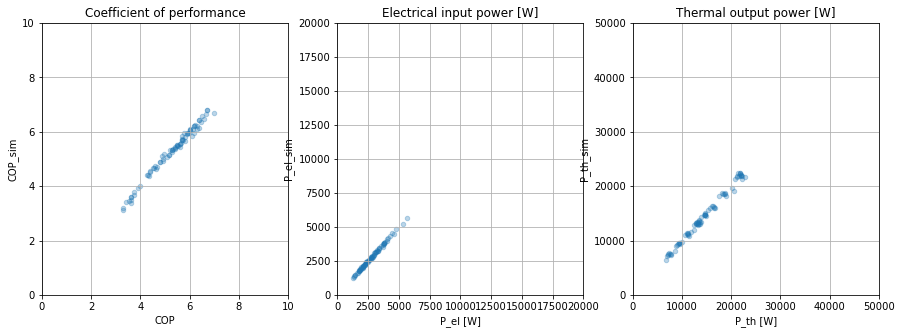

In [24]:
# Plot results for Group 6: Water/Water | On-Off
Group = 6
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(15,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

## Conclusion
- On/Off heat pumps can be simulated very well (mean relative error < 6 %)
- Regulated heat pumps show relative mean errors about 20 %, because of the non-linearity of electrical input power and COP regarding different primary / secondary temperatures
- Despite of that, generic heat pumps should work well, because the median shows only a small relative error